# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at mlta-2023-spring@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [30]:
import subprocess
import sys

def run_command(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()
    print(output.decode('utf-8'))
    print(error.decode('utf-8'), file=sys.stderr)

# Install required packages
run_command(f"{sys.executable} -m pip install -q swig")
run_command(f"{sys.executable} -m pip install box2d==2.3.2 'gym[box2d]==0.25.2' box2d-py pyvirtualdisplay tqdm numpy==1.22.4 matplotlib")
run_command(f"{sys.executable} -m pip install box2d==2.3.2 box2d-kengz")
run_command(f"{sys.executable} -m pip install torch")
run_command(f"{sys.executable} -m pip freeze > requirements.txt")

# Print installed packages for verification
run_command(f"{sys.executable} -m pip list")

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeable



You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeable



You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeable
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)



You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.



Package                 Version
----------------------- ---------
absl-py                 1.4.0
altgraph                0.17.2
appnope                 0.1.3
asttokens               2.4.1
Box2D                   2.3.2
Box2D-kengz             2.3.3
box2d-py                2.3.5
cachetools              5.3.1
certifi                 2023.7.22
charset-normalizer      3.2.0
cloudpickle             3.1.0
comm                    0.2.0
contourpy               1.2.1
cycler                  0.12.1
debugpy                 1.8.0
decorator               5.1.1
exceptiongroup          1.1.3
executing               2.0.1
filelock                3.16.1
fonttools               4.54.1
fsspec                  2024.10.0
future                  0.18.2
google-auth             2.22.0
google-auth-oauthlib    1.0.0
grpcio                  1.56.2
gym                     0.25.2
gym-notices             0.0.8
idna                    3.4
importlib-metadata      6.8.0
importlib_resources     6.4.5
ipykernel           

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.




Next, set up virtual display，and import all necessaary packages.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
from gym.wrappers import StepAPICompatibility
from tqdm import tqdm

print("Imports completed successfully")

Imports completed successfully


# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [2]:
seed = 2023
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [3]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
# env = StepAPICompatibility(env, new_step_api=True)
fix(env, seed)

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [35]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state = env.reset()
print(initial_state)

[-0.00506535  1.413064   -0.5130838   0.09527162  0.00587628  0.11622101
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

1


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
observation, reward, done, info = env.step(random_action)

In [ ]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [ ]:
print(reward)

-1.4981841929643156


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

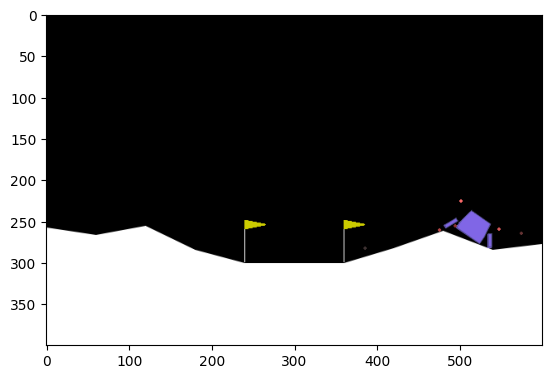

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Network & Agent
Now, we can build a simple policy network. The network will return one of action in the action space.

In [4]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(hid)
        return F.softmax(self.fc3(hid), dim=-1)

# Value Network
class ValueNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [5]:
from torch.optim.lr_scheduler import StepLR
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)
        self.scheduler = StepLR(self.optimizer, step_size=1000, gamma=0.9)
        self.rewards = None
        self.discounted_rewards = None

    def forward(self, state):
        return self.network(state)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def learn_A2C(self, log_probs, rewards, states, value_func):
        with torch.no_grad():
            values = value_func(states).squeeze()
        advantages = rewards - values
        loss = (-log_probs * advantages).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

## **Policy gradient**

In [6]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the agent every 5 episodes
NUM_BATCH = 500        # totally update the agent for 500 episodes
gamma = 0.99            # Discount factor

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # collect trajectory
    for episode in range(EPISODE_PER_BATCH):

        state = env.reset()
        total_reward, total_step = 0, 0
        episode_rewards = []  # Store episode-specific rewards

        while True:
            action, log_prob = agent.sample(state)  # at, log(at|st)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)  # Store log probability
            episode_rewards.append(reward)  # Store immediate reward
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

        # Convert episode rewards to discounted cumulative rewards
        discounted_rewards = []
        cumulative_reward = 0

        # Compute cumulative decaying rewards for the episode
        for r in reversed(episode_rewards):
            cumulative_reward = r + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)  # Insert at the front to keep the right order

        rewards.extend(discounted_rewards)  # Extend the rewards list with the episode's discounted rewards

    print(f"Rewards shape: {np.shape(rewards)}")

    # Record training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # Update the agent using cumulative decaying rewards
    rewards = np.array(rewards)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # Normalize the rewards
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

    # Print shapes for debugging
    print("Log probs size: ", torch.stack(log_probs).size())
    print("Rewards size: ", torch.from_numpy(rewards).size())

    # Print the AVG total reward achieved so far
    print(f"AVG Total Reward so far: {avg_total_reward:.2f}")


TypeError: __init__() missing 2 required positional arguments: 'input_dim' and 'output_dim'

## **Actor Critic**

In [ ]:
# Actor
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

# Value
value_func = ValueNet()
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.0005)

agent.network.train()  # Switch network into training mode
EPISODE_PER_BATCH = 5  # update the agent every 5 episodes
NUM_BATCH = 100         # totally update the agent for 500 episodes
gamma = 0.99           # Discount factor

avg_total_rewards, avg_final_rewards = [], []
vf_losses = []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    states = []

    # 收集轨迹
    for episode in range(EPISODE_PER_BATCH):

        state = env.reset()
        total_reward, total_step = 0, 0
        episode_rewards = []       # 存储每个episode的奖励
        episode_states = []        # 存储每个episode的状态
        episode_log_probs = []     # 存储每个episode的log概率

        while True:
            episode_states.append(state)  # 收集状态
            action, log_prob = agent.sample(state)  # at, log(at|st)
            next_state, reward, done, _ = env.step(action)

            episode_log_probs.append(log_prob)  # 存储log概率
            episode_rewards.append(reward)      # 存储即时奖励
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

        # 将每个episode的奖励转换为折扣累计奖励
        discounted_rewards = []
        cumulative_reward = 0

        # 计算每个episode的累计折扣奖励
        for r in reversed(episode_rewards):
            cumulative_reward = r + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)  # 在前面插入以保持正确顺序

        # 将每个episode的数据扩展到主列表
        rewards.extend(discounted_rewards)
        log_probs.extend(episode_log_probs)
        states.extend(episode_states)

    # 记录训练过程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 准备张量
    states = torch.FloatTensor(states)
    rewards = np.array(rewards)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 归一化奖励
    rewards = torch.FloatTensor(rewards)

    # 更新价值函数
    opt1.zero_grad()
    values = value_func(states).squeeze()
    vf_loss = F.mse_loss(values, rewards, reduction='sum')
    vf_loss.backward()
    opt1.step()

    vf_losses.append(vf_loss.item())

    # 使用优势Actor-Critic（A2C）更新策略网络
    log_probs = torch.stack(log_probs)
    agent.learn_A2C(log_probs, rewards, states, value_func)


    # 打印调试信息
    print("States size: ", states.size())
    print("Values size: ", values.size())
    print("Log probs size: ", log_probs.size())
    print("Rewards size: ", rewards.size())

    # 打印到目前为止的平均总奖励
    print(f"AVG Total Reward so far: {np.mean(avg_total_rewards):.2f}")



  0%|          | 0/100 [00:00<?, ?it/s]

States size:  torch.Size([431, 8])
Values size:  torch.Size([431])
Log probs size:  torch.Size([431])
Rewards size:  torch.Size([431])
AVG Total Reward so far: -259.08
States size:  torch.Size([418, 8])
Values size:  torch.Size([418])
Log probs size:  torch.Size([418])
Rewards size:  torch.Size([418])
AVG Total Reward so far: -246.13
States size:  torch.Size([398, 8])
Values size:  torch.Size([398])
Log probs size:  torch.Size([398])
Rewards size:  torch.Size([398])
AVG Total Reward so far: -231.52
States size:  torch.Size([454, 8])
Values size:  torch.Size([454])
Log probs size:  torch.Size([454])
Rewards size:  torch.Size([454])
AVG Total Reward so far: -237.59
States size:  torch.Size([479, 8])
Values size:  torch.Size([479])
Log probs size:  torch.Size([479])
Rewards size:  torch.Size([479])
AVG Total Reward so far: -208.97
States size:  torch.Size([515, 8])
Values size:  torch.Size([515])
Log probs size:  torch.Size([515])
Rewards size:  torch.Size([515])
AVG Total Reward so far: 

## **Training Result**
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


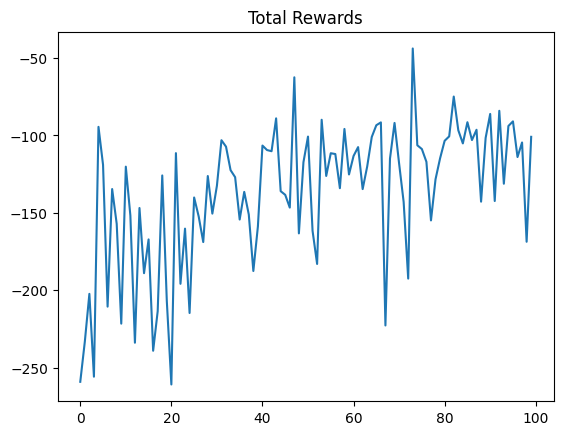

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


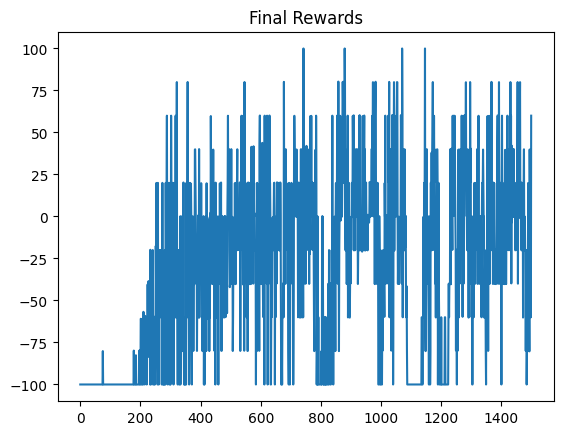

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

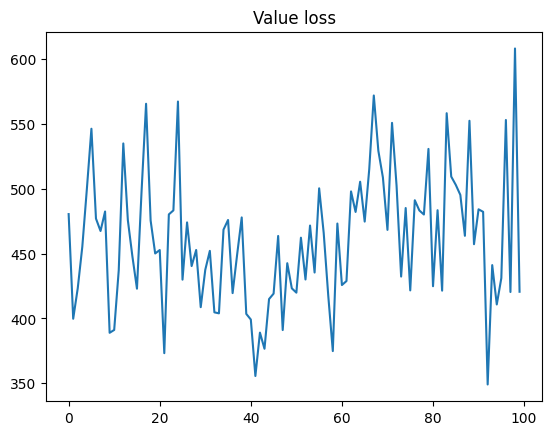

In [ ]:
plt.plot(vf_losses)
plt.title("Value loss")
plt.show()

## **DQN**
https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/01-dqn.ipynb

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden = nn.Linear(8, hidden_dim)
        self.output = nn.Linear(hidden_dim, 4)
    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

In [37]:
q_model = QNet().to(device)
q_target_model = QNet().to(device)
q_target_model.load_state_dict(q_model.state_dict()) #
_ = q_target_model.requires_grad_(False)  # target q-network doen't need grad

In [38]:
# Reply buffer
class ReplayMemory:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, sample_size):
        items = random.sample(self.buffer, sample_size)
        states = [i[0] for i in items]
        actions = [i[1] for i in items]
        rewards = [i[2] for i in items]
        n_states = [i[3] for i in items]
        dones = [i[4] for i in items]

        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        n_states = torch.tensor(n_states, dtype=torch.float).to(device)
        dones = torch.tensor(dones, dtype=torch.float).to(device)

        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

memory = ReplayMemory(buffer_size=10000)

In [39]:
gamma = 0.99

opt = torch.optim.Adam(q_model.parameters(), lr=0.0005)

# Function to optimize the Q-network
def optimize(states, actions, rewards, next_states, dones):
    with torch.no_grad():
        target_vals_for_all_actions = q_target_model(next_states)
        target_actions = torch.argmax(target_vals_for_all_actions, 1)
        target_actions_one_hot = F.one_hot(target_actions, env.action_space.n).float()
        target_vals = torch.sum(target_vals_for_all_actions * target_actions_one_hot, 1)
        target_vals_masked = (1.0 - dones) * target_vals
        q_vals1 = rewards + gamma * target_vals_masked

    opt.zero_grad()
    actions_one_hot = F.one_hot(actions, env.action_space.n).float()
    q_vals2 = torch.sum(q_model(states) * actions_one_hot, 1)
    loss = F.mse_loss(q_vals1.detach(), q_vals2, reduction="mean")
    loss.backward()
    opt.step()

In [40]:
# pick up action from q-network with greedy exploration
def pick_sample(s, epsilon):
    with torch.no_grad():
        # get optimal action,
        # but with greedy exploration (to prevent picking up same values in the first stage)
        if np.random.random() > epsilon:
            s_batch = torch.tensor(s, dtype=torch.float).to(device)
            s_batch = s_batch.unsqueeze(dim=0)  # to make batch with size=1
            q_vals_for_all_actions = q_model(s_batch)
            a = torch.argmax(q_vals_for_all_actions, 1)
            a = a.squeeze(dim=0)
            a = a.tolist()
        else:
            a = np.random.randint(0, env.action_space.n)
        return a
# evaluate current agent with no exploration
def evaluate():
    with torch.no_grad():
        s = env.reset()
        done = False
        total = 0
        while not done:
            a = pick_sample(s, 0.0)
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated  # Combine termination conditions
            total += r
            s = s_next
        return total


In [ ]:
from tqdm import tqdm

# Training parameters
sampling_size = 64 * 30
batch_size = 64
epsilon = 1.0
epsilon_decay = epsilon / 3000
epsilon_final = 0.1

reward_records = []

# Wrap the entire loop with tqdm for a single progress bar
for _ in tqdm(range(15000), desc="Training Progress"):
    done = True
    for _ in range(500):
        if done:
            s = env.reset()
            done = False
            cum_reward = 0

        a = pick_sample(s, epsilon)
        s_next, r, term, trunc, _ = env.step(a)
        done = term or trunc
        memory.add([s.tolist(), a, r, s_next.tolist(), float(term)])
        cum_reward += r
        s = s_next

    if memory.length() < 2000:
        continue

    # Optimize Q-network with a batch from replay memory
    states, actions, rewards, n_states, dones = memory.sample(sampling_size)
    states = torch.reshape(states, (-1, 8))
    actions = torch.reshape(actions, (-1,))
    rewards = torch.reshape(rewards, (-1,))
    n_states = torch.reshape(n_states, (-1, 8))
    dones = torch.reshape(dones, (-1,))

    for j in range(0, states.size(0), batch_size):
        optimize(
            states[j:j + batch_size],
            actions[j:j + batch_size],
            rewards[j:j + batch_size],
            n_states[j:j + batch_size],
            dones[j:j + batch_size]
        )

    # Evaluate and record rewards
    total_reward = evaluate()
    reward_records.append(total_reward)
    iteration_num = len(reward_records)
    print(f"Run iteration {iteration_num} rewards {total_reward:3} epsilon {epsilon:1.5f}")

    # Use \r to overwrite the line for smoother output within tqdm
    tqdm.write(f"Run iteration {iteration_num} rewards {total_reward:3} epsilon {epsilon:1.5f}")

    if iteration_num % 50 == 0:
        q_target_model.load_state_dict(q_model.state_dict())

    if epsilon - epsilon_decay >= epsilon_final:
        epsilon -= epsilon_decay

    if np.average(reward_records[-200:]) > 495.0:
       break

env.close()
print("\nDone")


In [45]:
reward_records

[-329.81356537213145,
 -474.8464202658307,
 -348.5777773381043,
 -322.3118033976525,
 -137.4222972263613,
 -1421.950974156293,
 -983.1956059130703,
 -765.0403254190945,
 -717.1813401561806,
 -742.952005813022,
 -690.5413958368523,
 -518.4642877159704,
 -398.5751597482757,
 -627.3635257311043,
 -921.0532030991734,
 -844.2158083357231,
 -998.279437353977,
 -767.9231586692761,
 -933.4255279975304,
 -849.4477646711116,
 -991.5969635135953,
 -520.4124573698225,
 -693.343078897801,
 -783.2872297039021,
 -191.22683209814582,
 -735.9603488649262,
 -845.2838932330975,
 -986.1723023905038,
 -1003.8009439028975,
 -834.9110838190173,
 -434.4478286027987,
 -991.6504889917477,
 -793.0378263505062,
 -692.5955455471143,
 -691.6025694109655,
 -659.2268025047534,
 -823.7584821137777,
 -446.2000802196025,
 -215.37117087413102,
 -608.51232551937,
 -681.9927307605936,
 -724.5481985974144,
 -417.43530212924077,
 -432.28396632221524,
 -912.3497700926548,
 -1031.1385489804363,
 -932.7426122530206,
 -320.29990

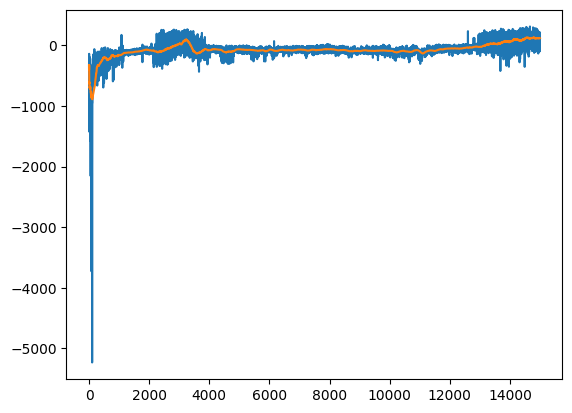

In [42]:
# Generate recent 150 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 150:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-149:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

## Testing
The testing result will be the average reward of 5 testing

AttributeError: 'numpy.float64' object has no attribute 'append'

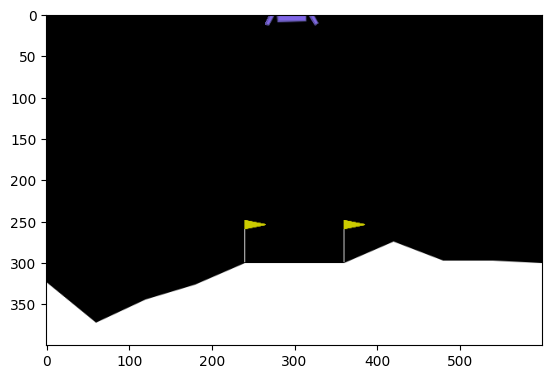

In [55]:
import torch

agent = q_model
fix(env, seed)
# agent.network.eval()  # set the network into evaluation mode

NUM_OF_TEST = 5  # Do not revise this !!!
test_total_reward = []
action_list = []

for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    total_reward = 0
    done = False

    while not done:
        # Convert the state to a PyTorch tensor and add batch dimension
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Get the action from the agent's forward pass
        action_values = agent.forward(state_tensor)
        action = torch.argmax(action_values, dim=1).item()  # Select the action with the highest value

        actions.append(action)
        # Take the action in the environment
        states, actions, reward, n_states, dones  = env.step(action)
        total_reward += reward

        # Update the rendering
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

    print(f"Test run {i + 1} reward: {total_reward}")
    test_total_reward.append(total_reward)
    action_list.append(actions)  # Save the result of testing

# Print the average reward over the test runs
print(f"Average reward over {NUM_OF_TEST} test runs: {np.mean(test_total_reward)}")


In [ ]:
print(np.mean(test_total_reward))

Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

Saving the result of Model Testing


In [ ]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list))

### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
from google.colab import files
files.download(PATH)

# Server
The code below simulate the environment on the judge server. Can be used for testing.

In [ ]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 2023 # Do not revise this
fix(env, seed)

agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:

      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
